In [867]:
import calendar
import pandas as pd
import jax.numpy as jnp
import jax
import jax.lax as lax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

import numpyro
import numpyro.distributions as dist

from functools import partial
from itertools import product
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from tqdm.auto import tqdm

plt.style.use('science')

In [868]:
input_filepath         = 'data/strawberry_river_arkansas_07074000.csv'
data  = pd.read_csv(input_filepath)
T     = 365*20
start = 8766 # New years day, 1972
data  = data.iloc[start:start+T]
data.index = pd.to_datetime(data[['year','month','day']]).values

### Annual summaries of precipitation, PET, and discharge

In [869]:
data[['p','pet','q']].mean() * 365

p      1673.946000
pet    1077.042300
q       644.143515
dtype: float64

In [872]:
q_obs  = data['q'].values
prec   = data['p'].values
etp    = data['pet'].values
dates  = data.index
dates[0],dates[-1]

### Start and end dates for period of record

In [895]:
dates[0],dates[-1]

(Timestamp('1972-01-01 00:00:00'), Timestamp('1991-12-26 00:00:00'))

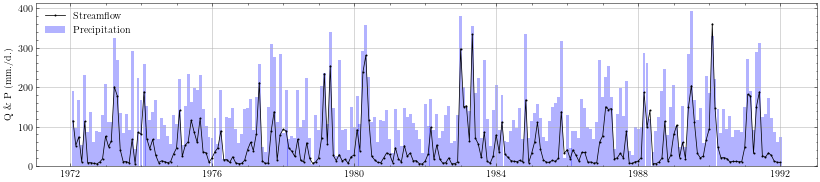

In [873]:
plt.figure(figsize=(14,3))
grouped = data.groupby(pd.Grouper(freq='M')).sum()
ax = plt.plot(grouped.index,grouped['q'].values, color='k',linewidth=0.75, marker='o',
              markersize=1, label='Streamflow')
plt.bar(grouped.index,height=grouped['p'].values, width=30, color='b',alpha=0.3, label='Precipitation')
plt.ylabel('Q \& P (mm./d.)')
plt.legend(loc='upper left')
plt.grid('on')


In [1001]:
@jax.jit
def update_state(state, xs, x1, x2, x3, uh1_ordinates, uh2_ordinates):
    
    '''
    Stateless update function for streamflow and reservoirs in GR4J model.
    '''
    # HARDCODING THESE NUMBERS TO PASS JIT ERRORS
    # THIS IS NOT GOOD! PLEASE FIX THIS SOON!
    # THESE ARE REFERENCED TO x4_max = 5
    num_uh1 = 5
    num_uh2 = 9
    
    s_store, r_store, uh1, uh2 = state

    # Convention for inputs 
    # is that E is first entry of xs and 
    # P is second
    etp   = xs[0]
    prec  = xs[1]
    
    is_wet = prec >= etp

    p_n_wet = prec - etp
    pe_n_wet = 0

    # calculate fraction of netto precipitation that fills
    #  production store (eq. 3)
    p_s_wet = ((x1 * (1 - (s_store / x1)**2) * jnp.tanh(p_n_wet/x1)) /
           (1 + s_store / x1 * jnp.tanh(p_n_wet / x1)))

    # no evaporation from production store
    e_s_wet = 0   

    p_n_dry = 0
    pe_n_dry = etp - prec

    # calculate the fraction of the evaporation that will evaporate 
    # from the production store (eq. 4)
    e_s_dry = ((s_store * (2 - s_store/x1) * jnp.tanh(pe_n_dry/x1)) 
           / (1 + (1 - s_store / x1) * jnp.tanh(pe_n_dry / x1)))

    # no rain that is allocation to the production store
    p_s_dry = 0

    p_s     = is_wet*p_s_wet  + (1-is_wet)*p_s_dry
    e_s     = is_wet*e_s_wet  + (1-is_wet)*e_s_dry
    pe_n    = is_wet*pe_n_wet + (1-is_wet)*pe_n_dry
    p_n     = is_wet*p_n_wet  + (1-is_wet)*p_n_dry

    # Calculate the new storage content
    s_store = s_store - e_s + p_s

    # calculate percolation from actual storage level
    perc = s_store * (1 - (1 + (4/9 * s_store / x1)**4)**(-0.25))

    # final update of the production store for this timestep
    s_store = s_store - perc

    # total quantity of water that reaches the routing
    p_r = perc + (p_n - p_s)

    # split this water quantity by .9/.1 for diff. routing (UH1 & UH2)
    p_r_uh1 = 0.9 * p_r 
    p_r_uh2 = 0.1 * p_r

    # update state of rain, distributed through the unit hydrographs
    uh1 = uh1.at[0:num_uh1 - 1].set(uh1[1: num_uh1] + uh1_ordinates[0:num_uh1-1]* p_r_uh1)
    uh1 = uh1.at[-1].set(uh1_ordinates[-1] * p_r_uh1)
    
    uh2 = uh2.at[0:num_uh2 - 1].set(uh2[1:num_uh2] + uh2_ordinates[0:num_uh2 - 1] * p_r_uh2)   
    uh2 = uh2.at[-1].set(uh2_ordinates[-1] * p_r_uh2)

    # calculate the groundwater exchange F (eq. 18)
    gw_exchange = x2 * (r_store / x3) ** 3.5

    # update routing store
    r_store = jnp.maximum(0, r_store + uh1[0] + gw_exchange)

    # outflow of routing store
    q_r = r_store * (1 - (1 + (r_store / x3)**4)**(-0.25))

    # subtract outflow from routing store level
    r_store = r_store - q_r

    # calculate flow component of unit hydrograph 2
    q_d = jnp.maximum(0, uh2[0] + gw_exchange)

    # total discharge of this timestep
    qsim = q_r + q_d
    
    return (s_store, r_store, uh1, uh2), qsim

@jax.jit
def update_state_tv_x1(state, xs, x2, x3, uh1_ordinates, uh2_ordinates):
    
    '''
    Stateless update function for streamflow and reservoirs in GR4J model.
    '''
    # HARDCODING THESE NUMBERS TO PASS JIT ERRORS
    # THIS IS NOT GOOD! PLEASE FIX THIS SOON!
    # THESE ARE REFERENCED TO x4_max = 5
    num_uh1 = 5
    num_uh2 = 9
    
    s_store, r_store, uh1, uh2 = state

    # Convention for inputs 
    # is that E is first entry of xs and 
    # P is second
    etp   = xs[0]
    prec  = xs[1]
    x1    = xs[2]
    
    is_wet = prec >= etp

    p_n_wet = prec - etp
    pe_n_wet = 0

    # calculate fraction of netto precipitation that fills
    #  production store (eq. 3)
    p_s_wet = ((x1 * (1 - (s_store / x1)**2) * jnp.tanh(p_n_wet/x1)) /
           (1 + s_store / x1 * jnp.tanh(p_n_wet / x1)))

    # no evaporation from production store
    e_s_wet = 0   

    p_n_dry = 0
    pe_n_dry = etp - prec

    # calculate the fraction of the evaporation that will evaporate 
    # from the production store (eq. 4)
    e_s_dry = ((s_store * (2 - s_store/x1) * jnp.tanh(pe_n_dry/x1)) 
           / (1 + (1 - s_store / x1) * jnp.tanh(pe_n_dry / x1)))

    # no rain that is allocation to the production store
    p_s_dry = 0

    p_s     = is_wet*p_s_wet  + (1-is_wet)*p_s_dry
    e_s     = is_wet*e_s_wet  + (1-is_wet)*e_s_dry
    pe_n    = is_wet*pe_n_wet + (1-is_wet)*pe_n_dry
    p_n     = is_wet*p_n_wet  + (1-is_wet)*p_n_dry

    # Calculate the new storage content
    s_store = s_store - e_s + p_s

    # calculate percolation from actual storage level
    perc = s_store * (1 - (1 + (4/9 * s_store / x1)**4)**(-0.25))

    # final update of the production store for this timestep
    s_store = s_store - perc

    # total quantity of water that reaches the routing
    p_r = perc + (p_n - p_s)

    # split this water quantity by .9/.1 for diff. routing (UH1 & UH2)
    p_r_uh1 = 0.9 * p_r 
    p_r_uh2 = 0.1 * p_r

    # update state of rain, distributed through the unit hydrographs
    uh1 = uh1.at[0:num_uh1 - 1].set(uh1[1: num_uh1] + uh1_ordinates[0:num_uh1-1]* p_r_uh1)
    uh1 = uh1.at[-1].set(uh1_ordinates[-1] * p_r_uh1)
    
    uh2 = uh2.at[0:num_uh2 - 1].set(uh2[1:num_uh2] + uh2_ordinates[0:num_uh2 - 1] * p_r_uh2)   
    uh2 = uh2.at[-1].set(uh2_ordinates[-1] * p_r_uh2)

    # calculate the groundwater exchange F (eq. 18)
    gw_exchange = x2 * (r_store / x3) ** 3.5

    # update routing store
    r_store = jnp.maximum(0, r_store + uh1[0] + gw_exchange)

    # outflow of routing store
    q_r = r_store * (1 - (1 + (r_store / x3)**4)**(-0.25))

    # subtract outflow from routing store level
    r_store = r_store - q_r

    # calculate flow component of unit hydrograph 2
    q_d = jnp.maximum(0, uh2[0] + gw_exchange)

    # total discharge of this timestep
    qsim = q_r + q_d
    
    return (s_store, r_store, uh1, uh2), qsim


@jax.jit
def run_gr4j(prec, etp, params):
    
   
    # Number of simulation timesteps
    num_timesteps = len(prec)
    
    # Unpack the model parameters
    x1, x2, x3, x4, s_init, r_init = params
    
    if x1.size > 1:
        tv_x1 = True
    else:
        tv_x1 = False
    
    # initialize empty arrays for discharge and all storages
    s_store = jnp.zeros(num_timesteps+1)
    r_store = jnp.zeros(num_timesteps+1)
    qsim    = jnp.zeros(num_timesteps+1)
    
    # set initial values
    if tv_x1:
        s_store = s_store.at[0].set(s_init * x1[0])
    else:
        s_store = s_store.at[0].set(s_init * x1)
        
    r_store = r_store.at[0].set(r_init * x3)
    
    # calculate number of unit hydrograph ordinates
    x4_max = 5
    
    uh1_ordinates, uh2_ordinates = hydrograms(x4_max, x4)
 
    # arrays to store the rain distributed through the unit hydrographs
    uh1 = jnp.zeros(num_uh1)
    uh2 = jnp.zeros(num_uh2)
    if tv_x1:
        forcing = jnp.stack([etp, prec, x1], axis=1)
        update_fn = partial(update_state_tv_x1, x2=x2, x3=x3,
                                uh1_ordinates=uh1_ordinates,
                                uh2_ordinates=uh2_ordinates)
        
    else:
        forcing = jnp.stack([etp,prec], axis=1)
        update_fn = partial(update_state, x1=x1, x2=x2, x3=x3,
                                uh1_ordinates=uh1_ordinates,
                                uh2_ordinates=uh2_ordinates)
    

    init    = (s_init, r_init, uh1, uh2)

    # We don't cary about the unit hydrographs, so throw them
    # away here.
    outs, qsim = jax.lax.scan(update_fn, init, forcing)
    s_store, r_store, uh1, uh2  = outs

    return qsim, outs

def soft_if(x, breakpoint, sharpness=10):
    return jax.nn.sigmoid(sharpness*(x-breakpoint))

def hydrograms(x4_limit, x4, sigmoid_a=5):
    
    timesteps = jnp.arange(2*x4_limit)
    late_multiplier      = soft_if(timesteps, x4)
    early_multiplier     = 1 - late_multiplier
    recession_multiplier = late_multiplier * (1-soft_if(timesteps, 2*x4)) 
    
    SH1 = early_multiplier * ((timesteps/x4)**2.5) + late_multiplier * 1.
    #SH1  = tt.switch(timesteps <= x4,(timesteps/x4)**2.5, 1.0)
    SH2A = early_multiplier * 0.5 * (timesteps/x4)**2.5
    #SH2A = tt.switch(timesteps <= x4, 0.5 * (timesteps/x4)**2.5,0)
    SH2B = recession_multiplier * (1 - 0.5 * (2 - timesteps/x4)**2.5)
    
    '''SH2B = tt.switch(( x4 < timesteps) & (timesteps <= 2*x4),
                     1 - 0.5 * (2 - timesteps/x4)**2.5,0)'''

    # The next step requires taking a fractional power and
    # an error will be thrown if SH2B_term is negative.
    # Thus, we use only the positive part of it.
    SH2B_term = jnp.maximum((2 - timesteps/x4),0)
    SH2B      = recession_multiplier*(1 - 0.5 * SH2B_term**2.5)
    SH2C      = jax.nn.sigmoid(-sigmoid_a*timesteps - 2*x4)
    
    SH2 = SH2A + SH2B + SH2C
    UH1 = SH1[1::] - SH1[0:-1]
    UH2 = SH2[1::] - SH2[0:-1]
    return UH1, UH2

In [1002]:
for inp in [q_obs, etp, prec]:
    assert np.all(np.isfinite(inp))
    assert np.all(inp >= 0)

In [1005]:
def model(q_obs=None, etp=None, prec=None, tv_x1=False, tv_resolution=10, timesteps_to_keep=None):
    
    T = len(q_obs)

    logx = numpyro.sample('logx',dist.Normal(loc=jnp.zeros(4)))
    ub = jnp.array([1000, 5., 200, 5])
    lb = jnp.array([100, -1., 10,  1])
    deltas = ub - lb
    x = numpyro.deterministic('x', (1 / (1+jnp.exp(-logx)) * deltas + lb))

    # In order production store, routing store
    init   = numpyro.sample('init', dist.Uniform(
                                         low=jnp.array([0.0, 0.0]),
                                         high=jnp.array([1.0,1.0])))


    err_sd = numpyro.sample('err_sd', dist.HalfCauchy(scale=3))

    # x1...x4, production store s0, routing store r0
    params  = [x[0], x[1], x[2],x[3],init[0],init[1]]
    
    if tv_x1:
        n_increments = int(T/tv_resolution)
        grw_sd     = numpyro.sample('grw_sd', dist.HalfNormal(1.0))
        increments = numpyro.sample('normal', dist.Normal(loc=jnp.zeros(n_increments), scale=grw_sd))
        grw        = numpyro.deterministic('grw',  jnp.repeat(jnp.cumsum(increments), tv_resolution))
        params[0]  = numpyro.deterministic('tv_x1',jnp.squeeze(grw + params[0]))
    
    qsim, ancillary             = run_gr4j(prec, etp, params)
    s_store, r_store, uh1, uh2  = ancillary
    
    qsim    = numpyro.deterministic('qsim', qsim)
    
    if isinstance(timesteps_to_keep, type(None)):
        q_obs   = numpyro.sample('q_obs', dist.Normal(loc=qsim, scale=err_sd), obs=q_obs)
    else:
        q_obs   = numpyro.sample('q_obs', dist.Normal(loc=qsim[timesteps_to_keep], scale=err_sd), obs=q_obs[timesteps_to_keep])
    
    
nuts_kernel = NUTS(model, max_tree_depth=12)
mcmc    = MCMC(nuts_kernel, num_samples=5000, num_warmup=5000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, q_obs=q_obs, etp=etp, prec=prec, tv_x1=True)

trace = mcmc.get_samples()

  0%|          | 0/10000 [00:08<?, ?it/s]


KeyboardInterrupt: 

### Plots of scalar parameters

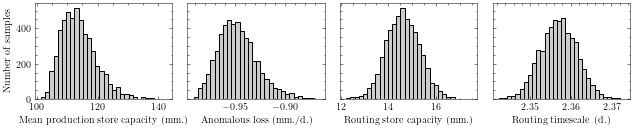

In [877]:
labels = [
    'Mean production store capacity (mm.)',
    'Anomalous loss (mm./d.)',
    'Routing store capacity (mm.)',
    'Routing timescale (d.)'
]
fig, axes = plt.subplots(1,4,figsize=(9,2), sharey=True)
axes      = axes.ravel()

[ax.hist(np.array(trace['x'][:,i]), bins=30, color='0.8', edgecolor='k') for i, ax in enumerate(axes)];
[axes[i].set_xlabel(label) for i, label in enumerate(labels)];
axes[0].set_ylabel('Number of samples')
plt.tight_layout()
plt.savefig('figures/strawberry_posterior.png', dpi=500)

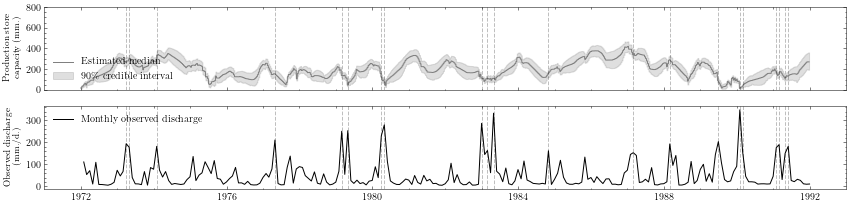

In [878]:
fig, axes = plt.subplots(2, figsize=(12,3), sharex=True)
big_event_threshold = 150
plt.sca(axes[0])
low, median, hi = np.percentile(trace['tv_x1'], q=[5,50,95], axis=0)
plt.plot(dates, median, color='0.5', label='Estimated median')
plt.fill_between(dates, low, hi, color='0.5', alpha=0.25, label='90\% credible interval')
plt.ylabel('Production store\ncapacity (mm.)', fontsize=9)
plt.ylim([0,800])
plt.legend(loc='lower left', facecolor='white', framealpha=0.5)

plt.sca(axes[1])
grouped = data['q'].groupby(pd.Grouper(freq='M')).mean()*30
plt.plot(grouped.index, grouped, color='k', label='Monthly observed discharge');
plt.ylabel('Observed discharge\n(mm./d.)', fontsize=9)
plt.legend(loc='upper left', facecolor='white', framealpha=0.5)

for i, q in enumerate(grouped.values):
    if q > big_event_threshold:
        axes[0].axvline(grouped.index[i], color='k', linestyle='--', alpha=0.25)
        axes[1].axvline(grouped.index[i], color='k', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.savefig('figures/tv_vs_discharge.png', dpi=500, bbox_inches='tight');


### Plot of year-vs-year comparisons of 12 month random walk trajectories

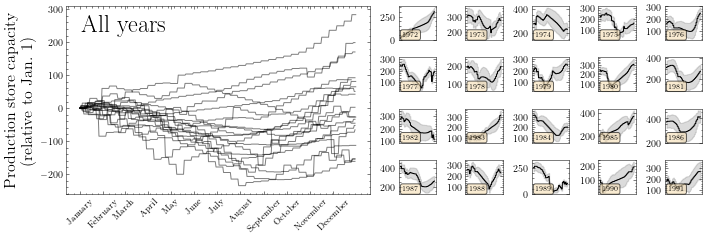

In [883]:
x1_df = pd.DataFrame(index=dates, data={'x1':median,'low':low,'high':hi, 'prec':prec})
x1_df['day']   = pd.to_datetime(x1_df.index).dayofyear
x1_df['month'] = pd.to_datetime(x1_df.index).month
x1_df['year']  = pd.to_datetime(x1_df.index).year

fig = plt.figure(tight_layout=True, figsize=(10,3.5))
gs = gridspec.GridSpec(4, 10)

main_ax    = fig.add_subplot(gs[0:4, 0:5])
small_axes = [fig.add_subplot(gs[i, j+5]) for i,j in product(range(4), range(5))]

bbox_props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)
xs = snippet.index.strftime('%m-%d')

month_starts = [  1,  32,  60,  91, 121, 152, 182, 213, 245, 275, 306, 336]

for year_idx, year in enumerate(x1_df['year'].unique()):
    snippet = x1_df[x1_df.year==year]
    main_ax.plot(snippet['day'], snippet['x1'] - snippet['x1'].iloc[0], color='k',
            alpha=0.5)
    small_axes[year_idx].plot(snippet['day'], snippet['x1'], color='k')
    small_axes[year_idx].fill_between(snippet['day'], snippet['low'], snippet['high'], color='0.3', alpha=0.2)
    small_axes[year_idx].text(0.1, 0.1, year, transform=small_axes[year_idx].transAxes, fontsize=7,
                             bbox=bbox_props, fontweight='bold')
    small_axes[year_idx].set_xticks([],[])
    #twinax = small_axes[year_idx].twinx()
    #twinax.invert_yaxis()
    #twinax.plot(snippet['day'], snippet.groupby('month')['prec'].sum())

month_names  =  list(calendar.month_name)[1:]
main_ax.set_xticks(month_starts, month_names, rotation=45, fontsize=9);
main_ax.set_ylabel('Production store capacity\n(relative to Jan. 1)', fontsize=16)
main_ax.text(0.05, 0.95, 'All years', transform=main_ax.transAxes, fontsize=24, va='top', ha='left')
plt.savefig('figures/year_snippets.png', dpi=500)

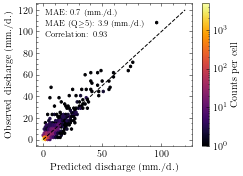

In [884]:
event_threshold = 5
q_hat = trace['qsim'].mean(axis=0)
corr  = np.corrcoef(q_hat,q_obs)[1,0]

mae   = np.abs(q_hat - q_obs).mean()
mae_event = np.abs(q_hat[q_obs>event_threshold] - q_obs[q_obs>event_threshold]).mean()
hb = plt.hexbin(q_hat, q_obs, bins='log', cmap='inferno',gridsize=50)
plt.plot([0,120],[0,120],color='k',linestyle='--')
cb = plt.colorbar(hb, ax=plt.gca(), label='Counts per cell')
plt.ylabel('Observed discharge (mm./d.)')
plt.xlabel('Predicted discharge (mm./d.)')

plt.text(2, 115, f'MAE: {mae:.1f} (mm./d.)', fontsize=8)
plt.text(2, 105, f'MAE (Q$\ge${event_threshold}): {mae_event:.1f} (mm./d.)', fontsize=8)
plt.text(2, 95, f'Correlation: {corr:.2f}', fontsize=8)

plt.savefig('figures/true_vs_pred_strawberry_river.png', dpi=500, bbox_inches='tight')

In [ ]:
for window in [30, 100, 365]:
    data[f'p_{window}']  = data['p'].rolling(window).mean().values
data['median'] = median
data.corr()

### Generating multiresolution results

In [887]:
resolutions = [365, 100, 25, 10, 5, 1]
traces = {}

In [896]:
for res in resolutions:
    nuts_kernel = NUTS(model, max_tree_depth=11)
    mcmc        = MCMC(nuts_kernel, num_samples=5000, num_warmup=5000)
    rng_key     = random.PRNGKey(0)
    
    mcmc.run(rng_key, q_obs=q_obs, etp=etp, prec=prec, tv_x1=True, tv_resolution=res)
    traces[res] = mcmc.get_samples()
pickle.dump(traces, open('traces/jax-multires.pkl', 'wb'))

sample: 100%|██████████| 10000/10000 [1:09:03<00:00,  2.41it/s, 3 steps of size 1.03e-05. acc. prob=0.70]  


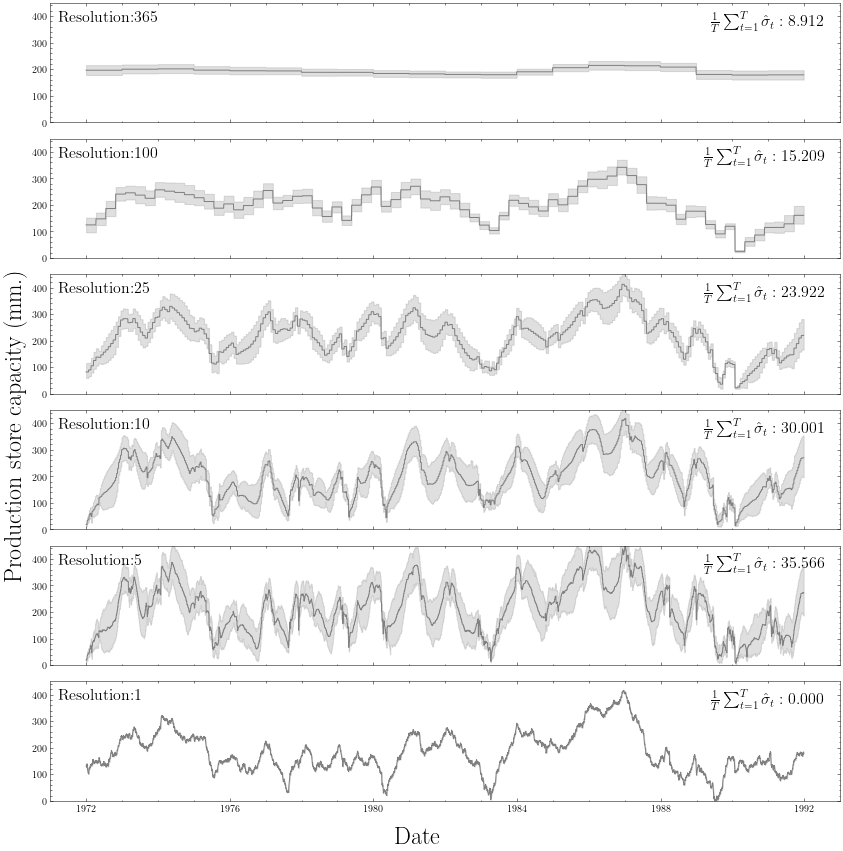

In [999]:
n_res = len(resolutions)

fig, axes = plt.subplots(n_res, figsize=(12,n_res*2), sharey=True, sharex=True)
axes = axes.ravel()
for i, (res, trace) in enumerate(traces.items()):
    plt.sca(axes[i])
    low, median, hi = np.percentile(trace['tv_x1'], q=[5,50,95], axis=0)
    avg_sigma = np.std(trace['tv_x1'], axis=0).mean()

    plt.plot(dates, median, color='0.5')
    plt.text(0.01, 0.94, f'Resolution:{res}', transform=axes[i].transAxes, ha='left', va='top', fontsize=16)
    avg_str = f'$\\frac{{1}}{{T}}\\sum_{{t=1}}^T \\hat{{\\sigma}}_t : {avg_sigma:.3f}$'
    plt.text(0.98, 0.94, avg_str, transform=axes[i].transAxes, ha='right', va='top', fontsize=16)
    plt.fill_between(dates, low, hi, color='0.5', alpha=0.25)  
    plt.ylim([0,450])
    
fig.supylabel('Production store capacity (mm.)', fontsize=24)
fig.supxlabel('Date', fontsize=24)

plt.tight_layout()
plt.savefig('figures/varying_resolution.png', dpi=400, bbox_inches='tight')

In [1012]:
draws_selected = np.arange(0, 5000, 10)
timesteps      = np.arange(0, 7300, 10)
low_99, median, hi_99 = np.percentile(traces[10]['tv_x1'], q=[0.5,50,99.5], axis=0)

for i in tqdm(timesteps):
    plt.figure(figsize=(10,2))
    plt.xlim(dates[0], dates[-1])
    plt.fill_between(dates[0:i], low_99[0:i], hi_99[0:i], color='c', zorder=1)
    #plt.plot(dates[0:i], trace['tv_x1'][draws_selected, 0:i].T, color='b',linewidth=0.1)
    plt.plot(dates[0:i], median[0:i], color='k', zorder=2)
    plt.axis('off')
    plt.ylim(0,450)
    '''twinx = plt.twinx()
    twinx.set_ylim([0, 100])
    twinx.set_xlim(dates[0], dates[-1])
    twinx.plot(dates[0:i], q[0:i])'''
    plt.savefig(f'figures/animations/frame_{i}.png', dpi=600)
    plt.close()

  0%|          | 0/730 [00:00<?, ?it/s]

### Analyzing error bars as data is dropped

In [1007]:
ns  = [2, 8, 32, 128]
res = 25
traces_drop  = {}

for n in ns:
    timesteps_to_keep = np.arange(0, len(q_obs), n)
    
    nuts_kernel = NUTS(model, max_tree_depth=11)
    mcmc        = MCMC(nuts_kernel, num_samples=5000, num_warmup=5000)
    rng_key     = random.PRNGKey(0)
    
    mcmc.run(rng_key, q_obs=q_obs, etp=etp, prec=prec, tv_x1=True,
             tv_resolution=res,
             timesteps_to_keep=timesteps_to_keep)
    
    traces_drop[res] = mcmc.get_samples()
pickle.dump(traces_drop, open('traces/jax-dropped.pkl', 'wb'))

warmup:   1%|          | 80/10000 [04:32<9:23:06,  3.41s/it, 2047 steps of size 4.55e-03. acc. prob=0.75] 


KeyboardInterrupt: 